# ES 335 Assignment 1 - Question 2

In this questions, we were asked to run our implementation of the decision tree on the given dataset that was generated using the `make_classification` function from the `sklearn.datasets` module. We first randomly shuffle the data and then split it into training and testing sets (70% and 30% respectively). We then train our decision tree on the training set and evaluate its performance on the testing set.


In [1]:
# === Imports & setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Your implementations
from tree.base import DecisionTree
from metrics import accuracy, precision, recall

from sklearn.datasets import make_classification

np.random.seed(42)  # for reproducibility of splits/shuffles


We use the exact lines specified in the question to generate the 2D dataset and plot it.

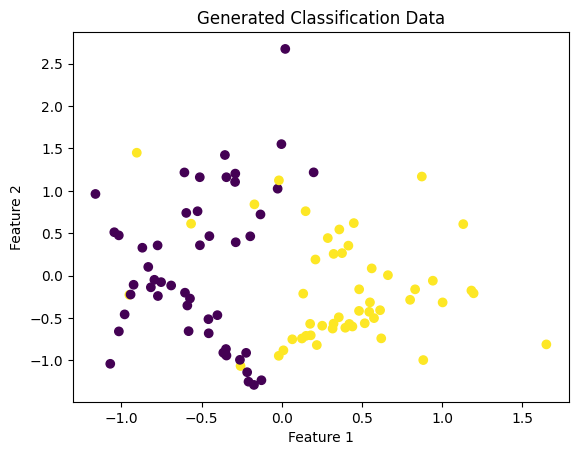

In [2]:
# === Data generation (as required) ===
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

X_df = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
y_df = pd.Series(y, name="target")

# === Scatter plot for visualization ===
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Generated Classification Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


We train `DecisionTree` and evaluate on the held-out **test** set. We report **accuracy, per-class precision, and recall** on the test set.


In [3]:
# === Split: first 70% train, last 30% test ===
split_index = int(0.7 * len(X_df))
X_train, X_test = X_df[:split_index], X_df[split_index:]
y_train, y_test = y_df[:split_index], y_df[split_index:]

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)
print("Classes:", np.unique(y_train))

# === Train model ===
tree = DecisionTree(criterion="information_gain", max_depth=3)
tree.fit(X_train, y_train)

# === Predict on test ===
y_pred = tree.predict(X_test)

# === Metrics on test ===
acc_score = accuracy(y_pred, y_test)
unique_class = sorted(y_df.unique())

print(f"\nTest Accuracy: {acc_score:.4f}")
for cls in unique_class:
    p = precision(y_pred, y_test, cls=cls)
    r = recall(y_pred, y_test, cls=cls)
    print(f"Class {cls} — Precision: {p:.4f}, Recall: {r:.4f}")


Training size: (70, 2)
Test size: (30, 2)
Classes: [0 1]

Test Accuracy: 0.8667
Class 0 — Precision: 0.9000, Recall: 0.7500
Class 1 — Precision: 0.8500, Recall: 0.9444


For the second part we do 5-fold nested cross-validation to find the best depth for the decision tree.

In [4]:
# === Helpers: Stratified folds & CV ===
def create_folds(X, y, n_folds=5):
    # Reset indices to ensure they start at 0 and are continuous
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    indices_per_class = {}
    for cls in np.unique(y):
        indices_per_class[cls] = y[y == cls].index.tolist()

    folds = [[] for _ in range(n_folds)]
    for cls, indices in indices_per_class.items():
        np.random.shuffle(indices)
        fold_size = len(indices) // n_folds
        for i in range(n_folds):
            start = i * fold_size
            end = len(indices) if i == n_folds - 1 else (i + 1) * fold_size
            folds[i].extend(indices[start:end])

    for fold in folds:
        np.random.shuffle(fold)
    return folds

def cross_validate_depth(X, y, depths, criterion="information_gain", n_folds=5):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    folds = create_folds(X, y, n_folds=n_folds)
    cv_results = {depth: [] for depth in depths}

    for fold_idx in range(n_folds):
        val_indices = folds[fold_idx]
        train_indices = []
        for i in range(n_folds):
            if i != fold_idx:
                train_indices.extend(folds[i])

        X_fold_train = X.iloc[train_indices]
        y_fold_train = y.iloc[train_indices]
        X_fold_val = X.iloc[val_indices]
        y_fold_val = y.iloc[val_indices]

        for depth in depths:
            tree = DecisionTree(criterion=criterion, max_depth=depth)
            tree.fit(X_fold_train, y_fold_train)
            y_pred = tree.predict(X_fold_val)
            fold_acc = accuracy(y_pred, y_fold_val)
            cv_results[depth].append(fold_acc)

    return cv_results

def nested_cross_validation(X, y, depths, criterion='information_gain', n_folds=5):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    outer_fold_results = []
    optimal_depths = []
    outer_folds_indices = create_folds(X, y, n_folds=n_folds)

    for outer_fold in range(n_folds):
        test_indices = outer_folds_indices[outer_fold]
        train_val_indices = []
        for i in range(n_folds):
            if i != outer_fold:
                train_val_indices.extend(outer_folds_indices[i])
        X_train_val = X.iloc[train_val_indices]
        y_train_val = y.iloc[train_val_indices]
        X_test_outer = X.iloc[test_indices]
        y_test_outer = y.iloc[test_indices]

        # Inner CV (3-fold) to pick depth
        inner_cv_results = cross_validate_depth(X_train_val, y_train_val, depths, criterion=criterion, n_folds=3)

        depth_means = {d: float(np.mean(inner_cv_results[d])) for d in depths}
        optimal_depth = max(depth_means.keys(), key=lambda k: depth_means[k])
        optimal_depths.append(optimal_depth)

        # Train final model at optimal depth on train+val, test on outer fold
        final_model = DecisionTree(criterion=criterion, max_depth=optimal_depth)
        final_model.fit(X_train_val, y_train_val)
        y_pred_outer = final_model.predict(X_test_outer)
        outer_accuracy = accuracy(y_pred_outer, y_test_outer)
        outer_fold_results.append(float(outer_accuracy))

    return outer_fold_results, optimal_depths


In [5]:
# === Run nested CV & simple CV ===
depths = [1, 2, 3, 4, 5, 6, 7, 8]

outer_fold_results, optimal_depths = nested_cross_validation(X_df, y_df, depths)

print("Nested Cross-Validation Results:")
print(f"Optimal depths across outer folds: {optimal_depths}")
most_common_depth = max(set(optimal_depths), key=optimal_depths.count)
print(f"Most common optimal depth: {most_common_depth}")
print(f"Outer fold accuracies: {[f'{acc:.4f}' for acc in outer_fold_results]}")
print(f"Mean outer CV accuracy: {np.mean(outer_fold_results):.4f} ± {np.std(outer_fold_results):.4f}")

# Simple 5-fold CV for comparison
simple_cv_results = cross_validate_depth(X_df, y_df, depths, "information_gain", 5)
depth_stats = {d: {'mean': float(np.mean(simple_cv_results[d])), 'std': float(np.std(simple_cv_results[d]))} for d in depths}

optimal_depth_simple = max(depth_stats.keys(), key=lambda d: depth_stats[d]['mean'])
print("\nSimple 5-fold CV summary:")
for d in depths:
    print(f"Depth {d}: mean={depth_stats[d]['mean']:.4f}, std={depth_stats[d]['std']:.4f}")
print(f"\nSimple 5-fold CV optimal depth: {optimal_depth_simple}")
print(f"Simple CV accuracy: {depth_stats[optimal_depth_simple]['mean']:.4f} ± {depth_stats[optimal_depth_simple]['std']:.4f}")


Nested Cross-Validation Results:
Optimal depths across outer folds: [1, 1, 2, 2, 1]
Most common optimal depth: 1
Outer fold accuracies: ['0.9500', '0.8500', '0.9500', '0.8500', '0.8500']
Mean outer CV accuracy: 0.8900 ± 0.0490

Simple 5-fold CV summary:
Depth 1: mean=0.9000, std=0.0707
Depth 2: mean=0.9000, std=0.0707
Depth 3: mean=0.8900, std=0.0735
Depth 4: mean=0.8400, std=0.0663
Depth 5: mean=0.8500, std=0.0548
Depth 6: mean=0.8300, std=0.0245
Depth 7: mean=0.8200, std=0.0400
Depth 8: mean=0.8200, std=0.0400

Simple 5-fold CV optimal depth: 1
Simple CV accuracy: 0.9000 ± 0.0707


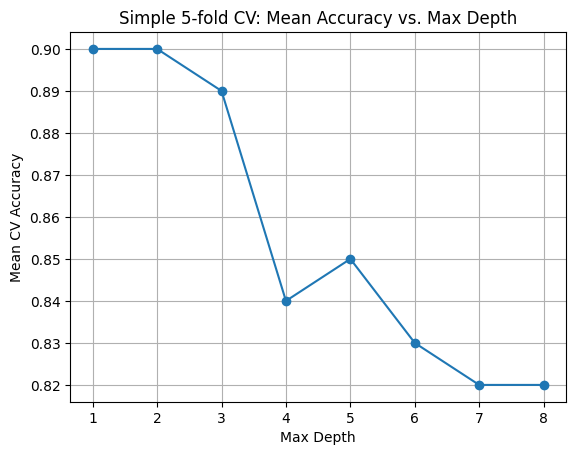

In [6]:
# (Optional) Visual: simple CV mean accuracy vs. depth
means = [depth_stats[d]['mean'] for d in depths]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(depths, means, marker='o')
plt.title("Simple 5-fold CV: Mean Accuracy vs. Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()
